## Description:
######Model type = LSTM
######Hidden layers = 128*2
######train seq_len = 500
######model id = lstm128-10


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np

import io

In [4]:
#mount google drive on colab for saving pytorch model variables
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Data Loading

In [5]:
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
test_data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_valid.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
with io.open(data_path, 'r', encoding = 'utf8') as f:
    text = f.read()
with io.open(test_data_path, 'r', encoding = 'utf8') as f:
    test_text = f.read()

chars = set(text)
tchars = set(test_text)
char2int = {c:i for i,c in enumerate(chars)}
int2char = dict(enumerate(chars))
nptext = np.array([char2int[ch] for ch in text])
npttext = np.array([char2int[ch] for ch in test_text])

N = nptext.shape[0]
tN = npttext.shape[0]
Nc = len(chars)
tNc = len(tchars)
for ele in tchars:
    assert(ele in chars)
print("all elememts in test data is in train data")
print("total train data length = {}, there are {} kinds of character".format(N, Nc))
print("total test data length = {}, there are {} kinds of character".format(tN, tNc))

all elememts in test data is in train data
total train data length = 4351312, there are 67 kinds of character
total test data length = 222025, there are 62 kinds of character


Hyper Params


In [0]:
#data
seq_len = 500
batch_size = 50
#model:
hidden_size = 128
n_layers = 2
#traininng:
n_epoch = 15
lr = 1e-4
dropout = 0.2
print_every = 1  #generate text per 2 epoch
plot_every = 100 #calc accuracy/loss per 100 batch
#model/record saving/loading:
LOAD = False
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
rec_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/rec/"
model_id = "lstm128-500" #save as 
load_model_name = None
rec_name = "rec-"+ model_id + ".pkl"
load_rec_name = "rec.pkl"

Preprocessing Data

In [7]:
from typing import List, Union #python 3.8 requried
num = Union[int, float]
def chunks(arr, chunk_len):
    for i in range(0, len(arr) - chunk_len, chunk_len):
        yield arr[i:i + chunk_len]

def s2tensor(s: str, device: str) -> torch.LongTensor:
    return torch.Tensor([char2int[s[i]] if s[i] in char2int else 0 for i in range(len(s))]).long().to(device)

def tensor2s(t: torch.Tensor) -> str:
    val = t.cpu().detach().numpy()
    ret = "" 
    return ret.join([int2char[val[i]] for i in range(len(val))])

#preprocessing train data:
seqs = list(chunks(nptext, seq_len + 1))
batches = list(chunks(seqs, batch_size))
train_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in batches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(train_data), train_data[0].shape)

#preprocessing test data:
tseqs = list(chunks(npttext, seq_len + 1))
tbatches = list(chunks(tseqs, batch_size))
test_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in tbatches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(test_data), test_data[0].shape)

173 torch.Size([501, 50])
8 torch.Size([501, 50])


Model

In [0]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, cell_type="rnn", n_layers=2, drop_out=0.2):
        super(CharRNN, self).__init__()
        self.cell_type = cell_type.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.cell_type == "rnn":
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, dropout=dropout)
        elif self.cell_type == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden) #print(output.shape)
        output = self.decoder(output) #print(output.shape)
        return output, hidden
    def forwardc(self, input, hidden, device='cpu'): #for characters : torch([long]) to distribution
        input = input.view(1, 1).to(device) #batch = 1, len = 1 #need to be added:to(device)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden)
        output = self.decoder(output)
        output = output.view(self.input_size)
        #print(output)
        return output, hidden

    def init_hidden(self, batch_size=batch_size, device='cpu'):
        if self.cell_type == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device))

Generate Prediction with temparature


In [0]:
def generate(model, device='cpu', seed='Juliet', predict_len=500, tau=0.8): 
    seed_tensor = s2tensor(seed, device) #shape = torch.Size([seqlen])
    #generate hidden 
    h = model.init_hidden(batch_size=1, device=device)
    for x in seed_tensor:
        _, h = model.forwardc(x, h, device)
    #generate seq
    inc = seed_tensor[-1]
    ret = seed
    for i in range(predict_len):
        out, h =  model.forwardc(inc, h, device)
        if tau >= 0.2 :
            tau_distribution = out.detach().data.view(-1).div(tau).exp()
            predi = torch.multinomial(tau_distribution, 1)[0]
        else : #prevent overflow
            _, predi = torch.max(out.detach().data, 0)
        ret += int2char[predi.item()]
        inc = torch.LongTensor([predi])
    return ret

In [0]:
def calc_accuracy(model, data, n_batch=10, device='cpu'):
    #eval accuracy for model on data with n_batch random batches, rach batch itself is continueous
    l = np.random.randint(0, len(data)-n_batch)
    r = l+n_batch
    correct_predictions = 0.0
    total = 0.0
    for batch_tensor in data[l:r]:
        hidden = model.init_hidden(batch_size=batch_tensor.size(1), device=device)
        input_variable = Variable(batch_tensor[:-1]).to(device)
        target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
        # prediction and calculate loss
        output, _ = model(input_variable, hidden)
        output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
        _, predicted = torch.max(output.data, 1)
        total += predicted.size(0)
        correct_predictions += (predicted.long() == target_variable.long()).sum()
    return (correct_predictions/total).item()

Test Functionality

In [12]:
def test_model(cell_type="rnn", device='cpu'):
    print("testing {} model".format(cell_type))
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2)
    model.to(device)
    print("test forward")
    tout, thidden = model(train_data[0].to(device), model.init_hidden(batch_size, device))
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test forwardc")
    tout, thidden = model.forwardc(torch.LongTensor([45]).to(device), model.init_hidden(1, device), device)
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test cal_accuracy")
    print(calc_accuracy(model, test_data, n_batch=2, device=device))
    print("test generate with forwardc")
    print(generate(model, device, tau=0.1), '\n')
test_model("rnn", "cuda")
test_model("lstm", "cuda")

testing rnn model
test forward
torch.Size([501, 50, 67]) torch.Size([2, 50, 128])
test forwardc
torch.Size([67]) torch.Size([2, 1, 128])
test cal_accuracy
0.007579999975860119
test generate with forwardc
JulietI,Iji]Ux,HFHHO'z?kh&yxXIxRNXKjy,Nj$:Tk-rkaUKXjy,$jy,mO:ayxMIUWTwBeOv[-QjN]:Z,xMHOXBS,'hpX.Z:[yy,DvARMX:Xkgbkkb&aNX;;!3Yp&-Q[NWTkdKs!&aN&a.:?yJX:?ylXKgjAxFWNAH:AyvXK3YpXB?]:Z,xjyIQjN&:?v[!MDK&aU;pM-MXIj$:?NAHO$kIKIjN&ayBX:v[-jy],-y,E?]:YNM?]N;!c].Z!WYlMMMMMFIXIjy,X:Q,mOv[-QjN]:Z,xFW?lXWT;pXBg,'hvUKXKgB-!UVnx:ayD$Ay,Djm:QjN]:ZNx
',xFWTkBs!XTkdC',SCpyy,Djv $kh&IxXIQ[-?]:YppXBx,HF:Gpy,NgXkY&av[-jyxX:X,D$QIlXWTkpyJgKNq&yJXKHOCHOWTkS&aNX:?NX:D]QQ,m:',xFWxksKi!&ayBxFWNA$:m&y,SjNq&yxXIQWlXdg-3JQjN&ay,.F 

testing lstm model
test forward
torch.Size([501, 50, 67]) torch.Size([2, 50, 128]) torch.Size([2, 50, 128])
test forwardc
torch.Size([67]) torch.Size([2, 1, 128]) torch.Size([2, 1, 128])
test cal_accuracy
0.03779999911785126
test generate with forwardc
Julietrrrrrrrrrrrrrrrrrrrrrrrrrrrr

Train

Build new model

In [13]:
if not LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type="lstm", n_layers=2)
    record = {
        'loss' : [],
        'trainAC' : [],
        'testAC' : []
    }
    print("new model and record initted")

new model and record initted


Load saved model

In [0]:
if LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type="lstm", n_layers=2)
    model.load_state_dict(torch.load(model_path+load_model_name)['model'])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer.load_state_dict(torch.load(model_path+load_model_name)['optimizer'])
    print('Model parameters loaded from disk.')
    import pickle
    with open(rec_path+load_rec_name, "rb") as fo: 
        record = pickle.load(fo)
    print('Records loaded from disk.')

Use GPU if available

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("model device : ", device)

model device :  cuda:0


In [0]:
import tqdm #set position and leave for colab
import time

def train():
    if not LOAD: 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()
    hidden = model.init_hidden(batch_size, device)
    model.train()
    try:
        #epoch_progress = tqdm.tqdm(range(1, n_epoch + 1),position=0, leave=True)
        best_ep_loss = float('inf')
        for epoch in range(1, n_epoch + 1):
            np.random.shuffle(train_data)
            batches_progress = tqdm.tqdm(train_data, position=0, leave=True)
            ep_loss = 0.0
            ep_train_ac = 0.0
            ep_test_ac = 0.0
            cnt = 0.0
            for batch, batch_tensor in enumerate(batches_progress):
                model.train()
                # reset gradients
                model.zero_grad()
                # data
                input_variable = Variable(batch_tensor[:-1]).to(device)
                target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
                # prediction
                output, _ = model(input_variable, hidden)
                output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
                #loss and backward
                loss = loss_function(output, target_variable)
                loss.backward()
                optimizer.step()
                #record
                if batch%plot_every == 0:
                    _, predicted = torch.max(output.data, 1)
                    total = predicted.size(0)
                    correct_predictions = (predicted.long() == target_variable.long()).sum()
                    train_ac = (correct_predictions*1.0/total).item()
                    test_ac = calc_accuracy(model, test_data, n_batch=1, device=device)
                    loss = loss.item()
                    record['loss'].append(loss), record['trainAC'].append(train_ac), record['testAC'].append(test_ac)
                    ep_loss += loss
                    ep_train_ac += train_ac
                    ep_test_ac += test_ac
                    cnt += 1.0
                    batches_progress.set_postfix(loss='{:.03f}'.format(loss), train_ac='{:.03f}'.format(train_ac), test_ac='{:.03f}'.format(test_ac))

            #epoch_progress.set_postfix(loss='{:.03f}'.format(ep_loss))
            model.eval()
            ep_loss /= cnt
            ep_train_ac /= cnt
            ep_test_ac /= cnt
            best_ep_loss = min(best_ep_loss, loss)
            #generate some ep string
            #time.sleep(0.01)
            tqdm.tqdm.write("\nAt {} epoche, loss = {:.03f}, train ac = {:.03f}, test ac = {:.03f}".format(epoch, ep_loss, ep_train_ac, ep_test_ac))
            seed = 'Juliet'
            tqdm.tqdm.write("RNN write with seed {}".format(seed))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write(generate(model, device, seed, 150))
            tqdm.tqdm.write("\n##############################\n")
            
            #save best model in ep as checkpoint
            if loss == best_ep_loss:
                checkpoint_path = os.path.join(model_path, model_id+'checkpoint_ep_'+str(epoch))+ str('{:.03f}'.format(loss)) + '.cp'
                torch.save({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }, checkpoint_path)

    except KeyboardInterrupt:
        pass

    #save
    model.eval()
    final_path = os.path.join(model_path, model_id+'final_checkpoint_')+ str('{:.03f}'.format(loss)) + '.cp' 
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }, final_path)
    import pickle
    with open(rec_path+rec_name, "wb") as fo: #wb
        pickle.dump(record,fo)
        print('Tranning records saved to disk.')

In [17]:
train()

  0%|          | 0/173 [00:00<?, ?it/s, loss=3.253, test_ac=0.157, train_ac=0.149]


At 1 epoche, loss = 3.757, train ac = 0.094, test ac = 0.095
RNN write with seed Juliet

##############################

Julietttl.yondd tndhu caei r ahe e s ain' et,hee
ag 
wTms Pde yoai tlne$ eeth tueh
 uteui rb:
asfhrerr isi ;eeuha du hb  i eee  s
en non e
ne deohdd nrio oi

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=2.986, test_ac=0.206, train_ac=0.207]


At 2 epoche, loss = 3.183, train ac = 0.168, test ac = 0.173
RNN write with seed Juliet

##############################

Juliet, eiteg on ose tiel hn eonml coy cel hme the
fI tecgus gtra uit ga are oe trhnhpy th t be ieo woonmh an. thrithd ewsMor nncaea nas atn ooaaen; patteet

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=2.717, test_ac=0.285, train_ac=0.283]


At 3 epoche, loss = 2.915, train ac = 0.228, test ac = 0.228
RNN write with seed Juliet

##############################

Juliet lte ru'lo
Uacire mey lfsa u aote rehar feltlawe
He bs me so csot:, e!e for yu hrsou aigp nhleoas nitie pas
 fs oTor hde mry
tuurg
hrils aco ads. Chee

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=2.562, test_ac=0.300, train_ac=0.299]


At 4 epoche, loss = 2.684, train ac = 0.286, test ac = 0.293
RNN write with seed Juliet

##############################

Julietrrnelas, wasth.
Tye ninde hhs lore to tan the tannfs oiy gath ka fee sere we gaso sore sroye,

oret ounte
hit,
BnreI: hpeac bgesnd enat he, asorl, Il 

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=2.436, test_ac=0.321, train_ac=0.328]


At 5 epoche, loss = 2.512, train ac = 0.311, test ac = 0.311
RNN write with seed Juliet

##############################

Juliethord the thert ais thes erere thar, ix

Uens the me ting urserou schaed Rate lo thaile il cescied ywe they as lerre?
-esded wean dorin tor scerray leu

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=2.389, test_ac=0.341, train_ac=0.338]


At 6 epoche, loss = 2.382, train ac = 0.337, test ac = 0.328
RNN write with seed Juliet

##############################

Juliet
Lound the ore e to me you cenend the sou lelm on of tult in.

HNIFRLNAA::
hit in mith ufle were bes the tith poameit, the than the sar; I the whe mre

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=2.284, test_ac=0.351, train_ac=0.353]


At 7 epoche, loss = 2.367, train ac = 0.338, test ac = 0.344
RNN write with seed Juliet

##############################

Juliet in on hous mod,-
omace love haits mours of in he shhund thele ald the thirre me cond olmes or's,
Mas
Mins gost cort Sonmy be atad covo'r the at our! 

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=2.219, test_ac=0.367, train_ac=0.370]


At 8 epoche, loss = 2.282, train ac = 0.353, test ac = 0.356
RNN write with seed Juliet

##############################

Julieteeld wore'nds on so showr anst the as saaland and orh;
And you unltinelg
To wes mat, mor here in.

LLFAR:n ese
in the cofmand care Candonr Wangos what

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=2.154, test_ac=0.379, train_ac=0.392]


At 9 epoche, loss = 2.219, train ac = 0.372, test ac = 0.370
RNN write with seed Juliet

##############################

Juliet sa! Courdting.

WOUE: unce in sorout ans belest efinter;s mcillee to she the mired in I me bomosen cerperceist, cistato theorr!

LEENDNDN:

Thot laes

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=2.206, test_ac=0.376, train_ac=0.370]


At 10 epoche, loss = 2.169, train ac = 0.387, test ac = 0.380
RNN write with seed Juliet

##############################

Juliet ach out onow, soush of and bath to, the thou noghod willele Thene; an sow kisow;
Where male fot mand the thow thou wion grist andersry the t? as path

##############################



  0%|          | 0/173 [00:00<?, ?it/s]


At 11 epoche, loss = 2.145, train ac = 0.388, test ac = 0.385
RNN write with seed Juliet

##############################

Juliet
I sows the noof miin thee how,
he my the Denend 'nt wath so of thee seill!

YOUW laat, whins me kance of plasters as god cined, frever and with you; 

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=2.116, test_ac=0.387, train_ac=0.390]


At 12 epoche, loss = 2.120, train ac = 0.393, test ac = 0.391
RNN write with seed Juliet

##############################

Julietinrs a sethes ret moteprer my; a theren.

OLYENUY:
Untarten you lost the minparde mare dea withnous that lyay lames a therey and fearer and sand there

##############################



  0%|          | 0/173 [00:00<?, ?it/s]


At 13 epoche, loss = 2.118, train ac = 0.390, test ac = 0.394
RNN write with seed Juliet

##############################

Juliet, wath too ferkeus hik more Anisses.

AUO NEONEY:
Acing you lodes!

CRELSDE:
Yor with the hould hite.

BANMLINE
TIS OO UFAR RUANRIB:
I, the serandas, 

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=2.037, test_ac=0.400, train_ac=0.416]


At 14 epoche, loss = 2.086, train ac = 0.398, test ac = 0.403
RNN write with seed Juliet

##############################

Juliet is your ave nom mesch wis lay I nome fyanst.

ITHEUO:
Be did sore, lomd not sperkend, in frothor?

ALPIIIE:
I gike of ivon ald of hir on ma's of cord

##############################



100%|██████████| 173/173 [00:08<00:00, 19.36it/s, loss=2.034, test_ac=0.414, train_ac=0.413]



At 15 epoche, loss = 2.036, train ac = 0.414, test ac = 0.407
RNN write with seed Juliet

##############################

Julietoy were tould more with goly the?

GVIRNRS:
Whall and or in thes mantluore thereat my in the parsty;
Bof but hape the wleis bestise?

HEISLS:
Les, ow 

##############################

Tranning records saved to disk.


In [22]:
train() #train for another 15 epoch

  0%|          | 0/173 [00:00<?, ?it/s, loss=2.049, test_ac=0.419, train_ac=0.405]


At 1 epoche, loss = 2.015, train ac = 0.415, test ac = 0.412
RNN write with seed Juliet

##############################

Julieter; and and enstsy?

ESRED:
I the prean the corese but in for with you folllo his herk'd
wave and of to shey sust not this high.


PARULENA:
Whol mire

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=2.002, test_ac=0.426, train_ac=0.427]


At 2 epoche, loss = 2.025, train ac = 0.411, test ac = 0.412
RNN write with seed Juliet

##############################

Juliet
But eand of be be spand wome't pleet fashs
that houlk homes no court, your bint'd of rochang.
A coust wowrom the greate in but of in the dade to'sty,

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.954, test_ac=0.410, train_ac=0.425]


At 3 epoche, loss = 1.984, train ac = 0.425, test ac = 0.419
RNN write with seed Juliet

##############################

Julietautsaan tim--

ROTENO:
Arsher
I'll, parce the aerent, and or,
And man I thee bine 'to mace the wond.

OLERCET:
My hik agily were cork your lick a auth

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=2.024, test_ac=0.412, train_ac=0.410]


At 4 epoche, loss = 1.985, train ac = 0.424, test ac = 0.418
RNN write with seed Juliet

##############################

Julietos, nor my comse:
And say there son do shall that comes spisiress
The nive a holades in miserfy
Lot will me sheer sto me wold paless with to greal.

A

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.932, test_ac=0.437, train_ac=0.435]


At 5 epoche, loss = 1.984, train ac = 0.423, test ac = 0.422
RNN write with seed Juliet

##############################

Julieter.

TAOS GIY:
Ay bold the hown hand.

RAPENI:
Sell, say whor tother to is
or sill these he uncerver!

USLONHA:
This sike to the my the that but noine

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.943, test_ac=0.423, train_ac=0.442]


At 6 epoche, loss = 1.939, train ac = 0.431, test ac = 0.430
RNN write with seed Juliet

##############################

Julietinusd,
And for, my lay you wou heard of wat
Nake do the speess.

SANIUS COAF:
I thing with all me coutt in, girg.

SECMOCUD:
Well sup priale, adpath t

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.888, test_ac=0.439, train_ac=0.442]


At 7 epoche, loss = 1.902, train ac = 0.447, test ac = 0.429
RNN write with seed Juliet

##############################

Juliet he Goss:
Mome, the may of a'then be jued the souk freen! bof theus alind.

SoPHand:
In his grind endish this my ounder for this bentes the made.

TAM

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.931, test_ac=0.422, train_ac=0.429]


At 8 epoche, loss = 1.911, train ac = 0.443, test ac = 0.434
RNN write with seed Juliet

##############################

Julietax;
As conding the heands of dows I did to pear the light you,
I hoven a mecare' are lets this and of the some
Age kainted and no minsile with to her 

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.857, test_ac=0.433, train_ac=0.448]


At 9 epoche, loss = 1.932, train ac = 0.433, test ac = 0.432
RNN write with seed Juliet

##############################

Juliet hong lidge thee salling and younged best of draam.

OGRDOL:
Coquish, and him, bear how go was the bake:
The choncles whell hese and my son a toumsand

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.889, test_ac=0.452, train_ac=0.444]


At 10 epoche, loss = 1.868, train ac = 0.451, test ac = 0.434
RNN write with seed Juliet

##############################

Juliet with
The care his true hast for no bether
If the krow
Fiplang trost wourse the that he the thall of for ead
Them my in and made.

MUCEF:
We so no con

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.850, test_ac=0.432, train_ac=0.446]


At 11 epoche, loss = 1.877, train ac = 0.446, test ac = 0.443
RNN write with seed Juliet

##############################

Julieter:
What a sall he night you print of feastem,
Where go her have and go you seer, in ous molieny you ingest-
The nore for the stonds, lature though do

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.894, test_ac=0.456, train_ac=0.444]


At 12 epoche, loss = 1.869, train ac = 0.445, test ac = 0.443
RNN write with seed Juliet

##############################

Juliet;
It me of will you, when the she and can sit
Thy we selled me for rerecuntion.

HARMINO:
Mike he seant make the till of shall the hir and anksen
abon

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.853, test_ac=0.434, train_ac=0.455]


At 13 epoche, loss = 1.857, train ac = 0.452, test ac = 0.455
RNN write with seed Juliet

##############################

Julieter,
The are not marin to a spay now
And kintrees my must are to down py lord:
What entle under of your sugh then; be mure!

FORENTO:
Lord to world bon

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.830, test_ac=0.446, train_ac=0.457]


At 14 epoche, loss = 1.839, train ac = 0.458, test ac = 0.439
RNN write with seed Juliet

##############################

Juliety
The usin at a know him wass
A with sturatuin!

COTERR:
The fall stertiom; bear reak may, and well where the ford.

PILIONS:

UCIDIO:

KING GHINCoD:


##############################



100%|██████████| 173/173 [00:09<00:00, 18.69it/s, loss=1.816, test_ac=0.461, train_ac=0.465]



At 15 epoche, loss = 1.823, train ac = 0.461, test ac = 0.453
RNN write with seed Juliet

##############################

Juliet,
It at the might you hing him are some
Mary away,
And didschuss; and your gribe eatter is,
Morsers, and the gart;
And shill I we will he rike that ho

##############################

Tranning records saved to disk.


After first 15 epoch


In [18]:
calc_accuracy(model, test_data, n_batch=len(test_data)-1, device=device)

0.41877713799476624

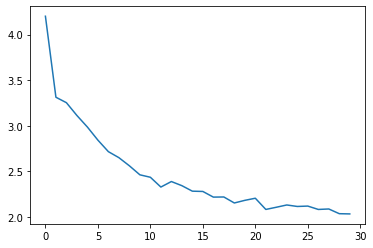

In [19]:
plt.figure()
plt.plot(record['loss'])
plt.show()

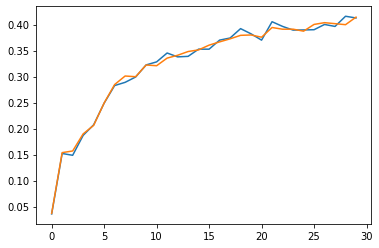

In [20]:
plt.figure()
plt.plot(record['trainAC'])
plt.plot(record['testAC'])
plt.show()

In [21]:
print(generate(model, device)) #default tau = 0.8

Juliet tom
You his. Tith of Flelibek, biindned.

DOLTEDRT:
I
Hell in by I well thee hill for save that now.
Where, I that to that thou the uncely and one not contaves whean anthes sipret.

FIOEN:
Toow mome and feathy the samk.

ELS:
That peaths my spiorn is cond than his rime, the thee puver afios,
The hit and boke hall he thy were most bosso hone!

LOORINA:
Coys nenet a willly thou,
For thy yoarser, you deand of the your andse of thin, word;
The ctanus be Vounver not he high the lich tithts and steve


In [0]:
print(generate(model, device, seed='juliet', tau=0.1), '\n') #deterministic
print(generate(model, device, seed='juliet', tau=2), '\n') #radom

In [0]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n') #middle, produce longer

After another 15 epcho(30)

In [23]:
calc_accuracy(model, test_data, n_batch=len(test_data)-1, device=device)

0.4613257050514221

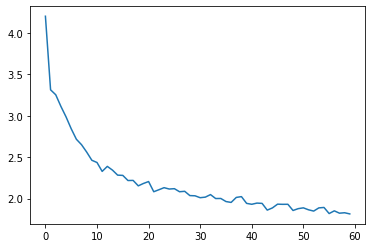

In [24]:
plt.figure()
plt.plot(record['loss'])
plt.show()

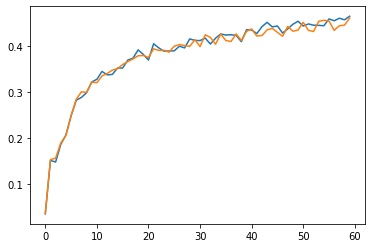

In [25]:
plt.figure()
plt.plot(record['trainAC'])
plt.plot(record['testAC'])
plt.show()

In [26]:
print(generate(model, device))

Juliet.

FULOT:
By that sty father thou draRmser'd not I
and groce is be wanters oun my more,
But sen hone diftot the bread? Fither my seet.

KANG:
That sone, me at my one him it our us it sich the at me
So main, of thy some soft, bood to love?
The galciece, a evering of not should lay the swife.

FARSINUF:
I heark the such and not his and sall of trieds.

FECLET:
Them nather were what are of the not.

HSLOCOGE:
Comes a medils indessand the and ame.

GALOMET:
When am, saveberise Ithing of lath!
The fi


In [27]:
print(generate(model, device))

Juliet.

ANTALO:
Carciin, lest to thou gosts statter, he knows,
To mistrich will wam thiy here tread theake?

FERWIDINS:
When the worful dow if the came to man, so llaberiess
The a mage me as conterst camerly.

HARO DANDARDUIO:
What be and you thound, whelph,
Sterch and mistriend to there good rey;
So know the she chalf! he distis, wand!

WRARIE:
Well'd that Mack! And is fall her carn and falther.

KAN GRONNINDA:
What thou uppontions booner the with the serin?

HLESNENITY:
Porman, to can, the have hav


In [29]:
print(generate(model, device))

Juliet?

YOCNASY:
My in or prick to live of here had you; and in of Pricf.

SIGEN:
I this offanstoned, you heaver in shall leapt the mare you
pilloss of that, Harding you crulate.

FERINDIO:
As do hast theur's the not now to my his to love and ellow:
That bord stands beged onfen will heart the mays?

UHER ERLOY:
Hath herge you rancess lose patiss with saul
Go hash a knowfon you mack and hit with a him.
Thy I to sighs of thou bode: be ow the grood:
And that prespetion in a faik cwome my light of the to


In [30]:
train()

  0%|          | 0/173 [00:00<?, ?it/s, loss=1.800, test_ac=0.437, train_ac=0.462]


At 1 epoche, loss = 1.791, train ac = 0.469, test ac = 0.457
RNN write with seed Juliet

##############################

Juliet, the pushich,
That is stink the father offet, where should your brasouse.

HALLA:
No horn!

SERTON:
Srain, and the I wive and tles onge, and in igin


##############################



  0%|          | 0/173 [00:00<?, ?it/s]


At 2 epoche, loss = 1.840, train ac = 0.458, test ac = 0.444
RNN write with seed Juliet

##############################

Juliet your say?

Shere:
Marry Dores,
And man my mights with! that you mould their beagainstemible
pared this and day of thou hoursed sodess the speape,
And

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.788, test_ac=0.461, train_ac=0.465]


At 3 epoche, loss = 1.842, train ac = 0.460, test ac = 0.453
RNN write with seed Juliet

##############################

Julieter, I be his thy plice the love and
This tragto and not but with oper-with she here
Otay, chay not saing fry upon my grance of come.

TINTINCUS:
A so 

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.838, test_ac=0.444, train_ac=0.456]


At 4 epoche, loss = 1.823, train ac = 0.463, test ac = 0.451
RNN write with seed Juliet

##############################

Julieter.

DRINGE PRANBERK:
Was in the reas the live easine they pritone.

CESFERS:
Joed some you shall neglenasisarn stacles,
That loves in blood your proa

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.827, test_ac=0.452, train_ac=0.461]


At 5 epoche, loss = 1.815, train ac = 0.462, test ac = 0.445
RNN write with seed Juliet

##############################

Julieted skee.

PARDIDUS:
What you say us so novender, bectore froth some
that the now stard ands in you mather to every
thought as to to like it it as will

##############################



  0%|          | 0/173 [00:00<?, ?it/s]


At 6 epoche, loss = 1.819, train ac = 0.462, test ac = 0.461
RNN write with seed Juliet

##############################

Julietion,
And wit my should helgulies the king of that sturring you.

TAMINES:
A ay to be us partes and pisces
If to the sin a dranging my compine.

MICSET

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.807, test_ac=0.459, train_ac=0.469]


At 7 epoche, loss = 1.787, train ac = 0.473, test ac = 0.459
RNN write with seed Juliet

##############################

Julieter as epenter
War a brever her lord Sorings.

MOMINGh:
I so monester whose the minshe fortuling
God, I have thou move speepe his winds dail,
And to th

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.763, test_ac=0.476, train_ac=0.477]


At 8 epoche, loss = 1.836, train ac = 0.460, test ac = 0.459
RNN write with seed Juliet

##############################

Julieters the wand, I shall thing,
The waken in but be one's dood pired is thee,
Thow the best thee be of game one's;
That his doth make's hever mange sears

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.830, test_ac=0.458, train_ac=0.459]


At 9 epoche, loss = 1.818, train ac = 0.462, test ac = 0.475
RNN write with seed Juliet

##############################

Julieted afferchives
Or his bout on as to be yether and like
That that in the purpesedensous bouth; you give come,
And send then in beress apparations of he

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.865, test_ac=0.474, train_ac=0.451]


At 10 epoche, loss = 1.825, train ac = 0.465, test ac = 0.467
RNN write with seed Juliet

##############################

Juliety, let to the
made hone? and now there of me:
Poensious ut of compise;
These a friend a witter of lovesam?

Sotomine:
Then, that twill here on is the 

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.806, test_ac=0.475, train_ac=0.467]


At 11 epoche, loss = 1.801, train ac = 0.464, test ac = 0.464
RNN write with seed Juliet

##############################

Juliet,
My have good Leever's heaks and me.

SODINPER:
Whemery eye, of good be but the hewselt worl-sy
Hack with ooth me. Who not a repent of my brown by
Re

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.763, test_ac=0.463, train_ac=0.474]


At 12 epoche, loss = 1.775, train ac = 0.480, test ac = 0.476
RNN write with seed Juliet

##############################

Julieter more thas deine,
Think, sir it told to so, dear!

ANGENTIO:
She soors the resuch the hand.

Ferraven:
Your a bright the shive and trief, better to 

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.721, test_ac=0.480, train_ac=0.491]


At 13 epoche, loss = 1.744, train ac = 0.481, test ac = 0.461
RNN write with seed Juliet

##############################

Julieter'd him
Les my hath our better prove in strilitle of his not here,
Which this have fortu her shies truy: the would.

First I Larratin:
The your late 

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.776, test_ac=0.465, train_ac=0.470]


At 14 epoche, loss = 1.746, train ac = 0.483, test ac = 0.480
RNN write with seed Juliet

##############################

Julietantice of the king,
The bland, and munter in shall meer prectilete of grander,
'Titer beporious of resing speited in to hath pome
That I many I wourt 

##############################



100%|██████████| 173/173 [00:08<00:00, 17.87it/s, loss=1.737, test_ac=0.466, train_ac=0.485]



At 15 epoche, loss = 1.756, train ac = 0.477, test ac = 0.465
RNN write with seed Juliet

##############################

Julieters to king
overeders and best then with and noble not vory
I and the wites a dromin and bance of what,
The slain a sains; I have here to time of the 

##############################

Tranning records saved to disk.


In [31]:
print(generate(model, device))

Juliether dead,
When the king frongen of to make of the chared me
That we asturatice wret, in thy long,
And a love now dear-of to we were not to mince,
Shich for for with engering him withan he read
This for me the worst that dost me.

CURIIUS:
You have my amners on your must his sent for when
bees my cure it of somend a dead from me.

ELARH:
The see, or which of your blest conpers.

COMONH:
He with good readen in our not bakes done it:
The one mine she be and but to me not that part,
And not was thou


In [32]:
calc_accuracy(model, test_data, n_batch=len(test_data)-1, device=device)

0.4863714277744293

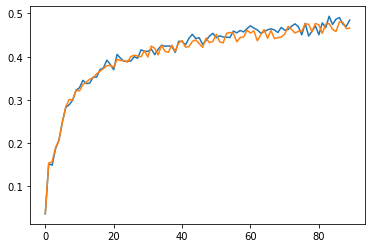

In [33]:
plt.figure()
plt.plot(record['trainAC'])
plt.plot(record['testAC'])
plt.show()

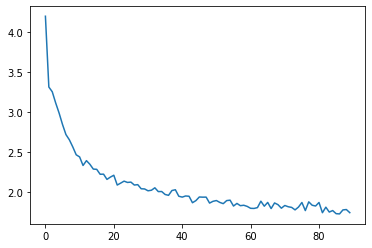

In [34]:
plt.figure()
plt.plot(record['loss'])
plt.show()

In [35]:
train()

  0%|          | 0/173 [00:00<?, ?it/s, loss=1.707, test_ac=0.483, train_ac=0.494]


At 1 epoche, loss = 1.740, train ac = 0.487, test ac = 0.471
RNN write with seed Juliet

##############################

Julieter's make and impallents,
But is fortwich with women of nauphention,
And and meet chonsow, I hollow she be bury.

PARBES IAL:
Not we thou stack to do 

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.760, test_ac=0.484, train_ac=0.479]


At 2 epoche, loss = 1.703, train ac = 0.493, test ac = 0.472
RNN write with seed Juliet

##############################

Julieto, he shall expe,
That were but grast upon the says, lord fick a
whick speak the father liest.

BYRATIUS:
Every these, was shall be gentle your livers

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.690, test_ac=0.488, train_ac=0.510]


At 3 epoche, loss = 1.772, train ac = 0.472, test ac = 0.482
RNN write with seed Juliet

##############################

Julieterian?

YRPEUS:
Seen my kispones, our man in me.

KING HENR:
I  come thou his your into on ent ness
This love bookness'd countreable, for the percomme

##############################



  0%|          | 0/173 [00:00<?, ?it/s]


At 4 epoche, loss = 1.704, train ac = 0.500, test ac = 0.480
RNN write with seed Juliet

##############################

Juliety wells sweet a

Thind a hamt of and the lirer and bout,
itiling fall begone is his neather.

PETRELIO:
My lord, I would I so canarellial?

OCTION:
Fo

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.726, test_ac=0.487, train_ac=0.484]


At 5 epoche, loss = 1.700, train ac = 0.501, test ac = 0.478
RNN write with seed Juliet

##############################

Julieters tlown now,
But strance him, there with ord, look, so them; and
The sond for a farture and sear, gropt,
How if thy part her for a are the fall resh

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.680, test_ac=0.474, train_ac=0.502]


At 6 epoche, loss = 1.699, train ac = 0.495, test ac = 0.475
RNN write with seed Juliet

##############################

Julieted; she have heart.

Secreven:
My crooks bottion the monding of the love;
And my soul must to tay in upon sent,
Such ender no the dightry and murring 

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.661, test_ac=0.488, train_ac=0.505]


At 7 epoche, loss = 1.713, train ac = 0.493, test ac = 0.478
RNN write with seed Juliet

##############################

Juliet hath marreds,
Which sulp's him as to be my sick.
Estech will the did not show has on the prince,
Indeak the couchse and merally, you day have mistrai

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.670, test_ac=0.477, train_ac=0.502]


At 8 epoche, loss = 1.736, train ac = 0.485, test ac = 0.487
RNN write with seed Juliet

##############################

Julieters opetchives;
Speak, and sine is the for out hing manted;
A wain, sir, and think far hath me;
That their hath so'er sir?

Sendost:
Ay, you set this 

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.728, test_ac=0.491, train_ac=0.483]


At 9 epoche, loss = 1.681, train ac = 0.497, test ac = 0.483
RNN write with seed Juliet

##############################

Julieter him she same
Of they dangers you.

HASTKEN:
Here they exceiss, and the fittle ence
Sto from my both a gate will be pardon,
When thou have all afd t

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.614, test_ac=0.489, train_ac=0.525]


At 10 epoche, loss = 1.702, train ac = 0.492, test ac = 0.491
RNN write with seed Juliet

##############################

Julietend light not if this
Caesing with him fret in the kingly brand.

TANENLE:
I that her gentlemen away; I would one stand.

Senst Lord:
Gencele, them, I

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.700, test_ac=0.490, train_ac=0.493]


At 11 epoche, loss = 1.649, train ac = 0.513, test ac = 0.488
RNN write with seed Juliet

##############################

Juliethan conford,
No monts seen it that some a good them he
'tis a know his most sin your forth's beance
Than my mother as yither to your revenge;
What it 

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.700, test_ac=0.481, train_ac=0.489]


At 12 epoche, loss = 1.650, train ac = 0.505, test ac = 0.485
RNN write with seed Juliet

##############################

Julieter prince: and adree to diverrenders
Be proness love, I daught the despering come, not the partase,
No, both the hand, in thy heatten father, sir.

HA

##############################



  0%|          | 0/173 [00:00<?, ?it/s, loss=1.726, test_ac=0.496, train_ac=0.486]


At 13 epoche, loss = 1.669, train ac = 0.500, test ac = 0.488
RNN write with seed Juliet

##############################

Julieten; then the in the
lunkest of my spends was but thee that leather,
I have think, 'tis kingly the canle.

IORGES:
For her so-master, I bear sim; us a 

##############################



  0%|          | 0/173 [00:00<?, ?it/s]


At 14 epoche, loss = 1.686, train ac = 0.495, test ac = 0.494
RNN write with seed Juliet

##############################

Julietenf, I will
by for know, who will the parts all of the
was now a work, and a love,
Hour did ever is forth man let hard, I die
Of these for sakes that 

##############################



100%|██████████| 173/173 [00:09<00:00, 18.88it/s, loss=1.731, test_ac=0.481, train_ac=0.497]



At 15 epoche, loss = 1.728, train ac = 0.491, test ac = 0.481
RNN write with seed Juliet

##############################

Julietly at love excellows,
The haths in a haalter. I will that in the false bloods
Would eye of speevers to his loven to me,
Ay a and and her of it the sec

##############################

Tranning records saved to disk.


0.49969714879989624


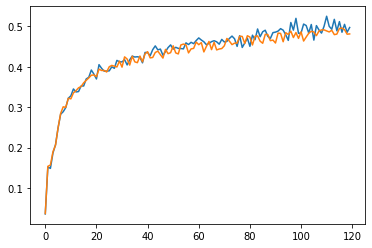

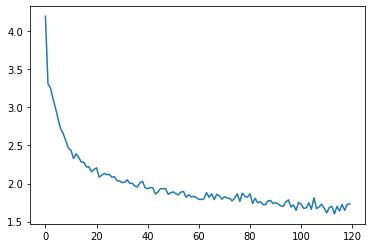

In [42]:
print(calc_accuracy(model, test_data, n_batch=len(test_data)-1, device=device))
plt.figure()
plt.plot(record['trainAC'])
plt.plot(record['testAC'])
plt.show()
plt.figure()
plt.plot(record['loss'])
plt.show()

In [40]:
print(generate(model, device))

Julieter of thee,
Tays a storust the stirs.

MARK ENNUTERO:
My liven not, my lord.

DUSELIUS:
If your confence his pains in thought all
A strender shall heaver and seesing me, come;
And the man me to.
The mother most propers. A foul not athinges!
When Sick the rovest of this praczeds as the other
going of bitch behand it it was is never,
Of Leiden of his saiminnt on here?

SALIUS ANYUS:
You hupp his his shall reson my wind, but this am.

PROSCELUT:
I have doth have shall she suge. And detriel,
So is n


In [48]:
print(generate(model, device, seed="I will")) #Lord

I willy wated the letters good.
For be sting sullren as the griencing our of that
ip reverent not forgerent she endied of the
Reaves of may for sleave to sand in his speak.

SROYLIO:
My lord,
For his ail father. Now so seed with so?

Hong Lord:
It send of my part to our I so mowges these to-doth
That I am sad lice of live that will see
Wiigh not and said in at mine favoices appeace
Of composhace of demand and my lord.

KING GHARV:
Dear, I will be sup; of the weits hen
than thy heart his trival oor fit


In [53]:
print(generate(model, device, seed="I will", tau=0.2)) #lstm with 500 length + deterministic, word tends to re-accur

I willy shall the seep the seep
The send the world the strange the seep of the world
And shall the court of the hands and be the send
The fair the man the stand the sear the sent of the send
The seem of the love the strange of the world.

LORTIN:
I was the dount of the store the seard of the seard
That the sees and do all the court of the more to my sent
And so man the did of the seed of the strange,
And the best the court of the fill the death,
And the strange the sent to the sent of the seard,
And t


In [57]:
print(generate(model, device, seed="I will", tau=0.25))

I willy store the streath
And that the wast the king the great the hands,
The strange the court of the stringer the court of me
The more the father of his fortunes, and the place the end the word.

First Castar:
I will not shall see the man the seard the send and some
With the sent of the words and the fortune.

LEONTES:
And the did so be the father the words of the court
The heart of the send the prove the property
And the sear of the hiss the hands in the words
The sear the present of the word the s


In [63]:
print(generate(model, device, seed="I will", tau=0.4)) #Second Citizen #hideen have more info, can use lower tau

I willed and and then I would more stand,
And she would not have me the dean to the gentle as let the
compose the name of a more to him the commons
And the father from the strumble thou shall seak,
And heart the court of the gods of the propers.

PERTIUS:
The king her for the part under the courted with the father,
With that she do the foul the best the soldier.

Second Citizen:
The and with him with a love the will as the couse
That see the did that shall de the dook:
Good more good strong and this h
